<a href="https://colab.research.google.com/github/kkkumar2/AUTONLP/blob/main/Name_entity_recognition_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==4.13.0
!pip install datasets==2.0.0
!pip install accelerate==0.5.1

# Named Entity Recognition

## The Dataset

In [ ]:
#id jeff-dean-ner
#caption An example of a sequence annotated with named entities
#hide_input
import pandas as pd
toks = "Jeff Dean is a computer scientist at Google in California".split()
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]
df = pd.DataFrame(data=[toks, lbls], index=['Tokens', 'Tags'])
df

,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


In [ ]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [ ]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [ ]:
# hide_output
from datasets import load_dataset

load_dataset("xtreme", name="PAN-X.en")

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
})

In [ ]:
en = load_dataset("xtreme", name='PAN-X.en')

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(en['train'][0])

{'tokens': ['R.H.', 'Saunders', '(', 'St.', 'Lawrence', 'River', ')', '(', '968', 'MW', ')'], 'ner_tags': [3, 4, 0, 3, 4, 4, 0, 0, 0, 0, 0], 'langs': ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en']}


In [ ]:
pd.DataFrame(en["train"][0]).transpose()

,0,1,2,3,4,5,6,7,8,9,10
tokens,R.H.,Saunders,(,St.,Lawrence,River,),(,968,MW,)
ner_tags,3,4,0,3,4,4,0,0,0,0,0
langs,en,en,en,en,en,en,en,en,en,en,en


In [ ]:
for key, value in en["train"].features.items():
    print(f"{key}: {value} \n")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None) 

ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None) 

langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None) 



In [ ]:
tags = en["train"].features["ner_tags"].feature
print(tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [ ]:
# hide_output
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_en = en.map(create_tag_names)

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/20000 [00:00<?, ?ex/s]

In [ ]:
# hide_output
de_example = panx_en["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10
Tokens,R.H.,Saunders,(,St.,Lawrence,River,),(,968,MW,)
Tags,B-ORG,I-ORG,O,B-ORG,I-ORG,I-ORG,O,O,O,O,O


In [ ]:
from collections import Counter
from collections import defaultdict
from datasets import DatasetDict
split2freqs = defaultdict(Counter)
for split, dataset in panx_en.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,ORG,LOC,PER
validation,4677,4834,4635
test,4745,4657,4556
train,9422,9345,9164


## Multilingual Transformers

## A Closer Look at Tokenization

In [ ]:
# hide_output
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [ ]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [ ]:
#hide_input
df = pd.DataFrame([bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])
df

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


### The SentencePiece Tokenizer

In [ ]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

## Transformers for Named Entity Recognition

<img alt="Architecture of a transformer encoder for classification." caption="Fine-tuning an encoder-based transformer for sequence classification" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter04_clf-architecture.png?raw=1" id="clf-arch"/>

<img alt="Architecture of a transformer encoder for named entity recognition. The wide linear layer shows that the same linear layer is applied to all hidden states." caption="Fine-tuning an encoder-based transformer for named entity recognition" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter04_ner-architecture.png?raw=1" id="ner-arch"/>

## The Anatomy of the Transformers Model Class

### Bodies and Heads

<img alt="bert-body-head" caption="The `BertModel` class only contains the body of the model, while the `BertFor&lt;Task&gt;` classes combine the body with a dedicated head for a given task" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter04_bert-body-head.png?raw=1" id="bert-body-head"/>

### Creating a Custom Model for Token Classification

In [ ]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)

### Loading a Custom Model

In [ ]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [ ]:
# hide_output
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [ ]:
xlmr_model_name

'xlm-roberta-base'

In [ ]:
# hide_output
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

In [ ]:
# hide_output
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [ ]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [ ]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC


In [ ]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])
    

## Tokenizing Texts for NER

In [ ]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [ ]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [ ]:
#hide_output
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Tokens,<s>,▁R,.,H,.,▁Sa,under,s,▁(,▁St,.,▁Lawrence,▁River,▁),▁(,▁9,68,▁MW,▁),</s>


In [ ]:
# hide_output
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Tokens,<s>,▁R,.,H,.,▁Sa,under,s,▁(,▁St,.,▁Lawrence,▁River,▁),▁(,▁9,68,▁MW,▁),</s>
Word IDs,None,0,0,0,0,1,1,1,2,3,3,4,5,6,7,8,8,9,10,None


In [ ]:
#hide_output
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx
    
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Tokens,<s>,▁R,.,H,.,▁Sa,under,s,▁(,▁St,.,▁Lawrence,▁River,▁),▁(,▁9,68,▁MW,▁),</s>
Word IDs,None,0,0,0,0,1,1,1,2,3,3,4,5,6,7,8,8,9,10,None
Label IDs,-100,3,-100,-100,-100,4,-100,-100,0,3,-100,4,4,0,0,0,-100,0,0,-100
Labels,IGN,B-ORG,IGN,IGN,IGN,I-ORG,IGN,IGN,O,B-ORG,IGN,I-ORG,I-ORG,O,O,O,IGN,O,O,IGN


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [ ]:
# hide_output
panx_de_encoded = encode_panx_dataset(panx_en)

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

## Performance Measures

In [ ]:
!pip install seqeval==1.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.5 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=96564d0cb6e2c82864b35a949616d6caa8d6ba01d41d69907ff63781b82060df
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [ ]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

## Fine-Tuning XLM-RoBERTa

In [ ]:
# hide_output
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps, push_to_hub=True)

In [ ]:
#hide_output
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [ ]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [ ]:
#hide
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [ ]:
# hide_output
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.
/home/lewtun/miniconda3/envs/book/lib/python3.7/site-packages/apscheduler/util.py:95: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  if obj.zone == 'local':


In [ ]:
#hide_input
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
# hide_input
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
df.drop_duplicates()

Epoch,Training Loss,Validation Loss,F1
1,0.2652,0.160244,0.822974
2,0.1314,0.137195,0.852747
3,0.0806,0.138774,0.864591


In [ ]:
# hide_output
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


## Cross-Lingual Transfer

In [ ]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [ ]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.868


In [ ]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [ ]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [ ]:
# hide_output
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

  0%|          | 0/5 [00:00<?, ?ba/s]

F1-score of [de] model on [fr] dataset: 0.714


In [ ]:
# hide_input
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

F1-score of [de] model on [fr] dataset: 0.714


In [ ]:
# hide_output
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

F1-score of [de] model on [it] dataset: 0.692


In [ ]:
# hide_input
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

F1-score of [de] model on [it] dataset: 0.692


In [ ]:
#hide_output
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

F1-score of [de] model on [en] dataset: 0.589


In [ ]:
#hide_input
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

F1-score of [de] model on [en] dataset: 0.589


### When Does Zero-Shot Transfer Make Sense?

In [ ]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size
    
    trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")
    
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [ ]:
# hide_output
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
# hide_output
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

In [ ]:
#hide_input
# Hack needed to exclude the progress bars in the above cell
metrics_df

,num_samples,f1_score
0,250,0.137329


In [ ]:
# hide_output
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

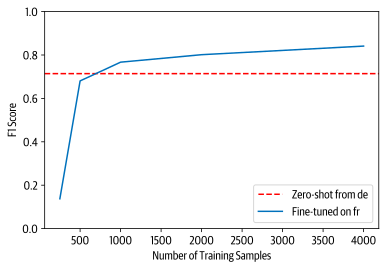

In [ ]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

### Fine-Tuning on Multiple Languages at Once

In [ ]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [ ]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [ ]:
# hide_output
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
#hide_output
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

F1-score of [de-fr] model on [de] dataset: 0.866
F1-score of [de-fr] model on [fr] dataset: 0.868
F1-score of [de-fr] model on [it] dataset: 0.815
F1-score of [de-fr] model on [en] dataset: 0.677


In [ ]:
#hide_input
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

F1-score of [de-fr] model on [de] dataset: 0.866
F1-score of [de-fr] model on [fr] dataset: 0.868
F1-score of [de-fr] model on [it] dataset: 0.815
F1-score of [de-fr] model on [en] dataset: 0.677


In [ ]:
# hide_output
corpora = [panx_de_encoded]

# Exclude German from iteration
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

In [ ]:
corpora_encoded = concatenate_splits(corpora)

In [ ]:
# hide_output
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")